In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm

from src import modelers

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prediction algorithms (supervised learning)
1. Linear Regression for predicted population count for each winner (multivariate linear regression)


1. Logistic (get beta values, or log odds ratio and look at predict proba)
2. KNN
3. Gradient Boosting Classifier (Random Forest)
Don't forget confusion matrix!!

4. We need state results (and electoral college votes) to see if they match for sum of county results.

Can we get updated demographic information to predict the 2020 elections?

5. Can we scrape twitter data and look at popularity? Maybe use NLP/NMF to look at latent features for the different tweets? Too ambitious....
6. Hate crime statistics? Starter code to download from github is in data_clean script




In [19]:
# Import data
pd.set_option("display.max_columns", 40)
data = pd.read_csv('data/cleaned_data2.csv')
data.head()

,Unnamed: 0,state,county,fips,white_pct,black_pct,hispanic_pct,foreignborn_pct,female_pct,age29andunder_pct,age65andolder_pct,median_hh_inc,clf_unemploy_pct,lesshs_pct,lesscollege_pct,rural_pct,trump16_pct,clinton16_pct,otherpres16_pct,romney12_pct,obama12_pct,otherpres12_pct,cvap_pct12,metro,rural,urban_metroadj,urban_not_metroadj
0,0,Alabama,Autauga,1001,75.683482,18.370906,2.572254,1.838362,51.176225,40.037058,13.978456,53099.0,5.591657,12.417046,75.407229,42.002162,72.766588,23.769671,3.463741,72.618252,26.587832,0.793916,58.815434,1,0,0,0
1,1,Alabama,Baldwin,1003,83.178788,9.225603,4.366698,3.269510,51.194928,35.474412,18.714851,51365.0,6.286843,9.972418,70.452889,42.279099,76.545712,19.385601,4.068687,77.358269,21.589444,1.052286,56.228504,1,0,0,0
2,2,Alabama,Barbour,1005,45.885624,47.888329,4.309762,2.859397,46.498084,37.664387,16.528895,33956.0,12.824738,26.235928,87.132213,67.789635,52.096666,46.527844,1.375490,48.223130,51.368494,0.408376,56.485890,0,0,1,0
3,3,Alabama,Bibb,1007,74.765196,21.212121,2.223994,1.351232,46.464646,37.329435,14.885699,39776.0,7.146827,19.301587,88.000000,68.352607,76.403220,21.249575,2.347205,72.826603,26.152019,1.021378,47.868107,1,0,0,0
4,4,Alabama,Blount,1009,87.657701,1.557951,8.727298,4.271801,50.485235,37.240053,17.192916,46212.0,5.953833,19.968585,86.950243,89.951502,89.334844,8.425825,2.239331,86.465884,12.371907,1.162209,56.577893,1,0,0,0


In [20]:
data.drop(columns=['Unnamed: 0', 'state', 'county', 'fips', 
                   'otherpres12_pct', 'black_pct', 'hispanic_pct'], inplace=True)

In [21]:
# Extract our labels
trump = data.pop('trump16_pct')
clinton = data.pop('clinton16_pct')
other = data.pop('otherpres16_pct')

In [22]:
# Make our X and y and do 75%/25% split
X = data
y = trump

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_trainn, X_testn = modelers.normalize(X_train, X_test)
rmse, r_sq, y_hat, model_coeff = modelers.lin_regression(X_trainn, X_testn, y_train, y_test)

# Keep track of indices
train_idx = X_train.index.values
test_idx = X_test.index.values

## Test toy model before using Kfold

In [26]:
# Standardize and fit model
X_trains, X_tests = modelers.standardize(X_train, X_test)
X_trainn, X_testn = modelers.normalize(X_train, X_test)
rmse, r_sq, y_hat, model_coeff = modelers.lin_regression(X_trainn, X_testn, y_train, y_test)
rmse, r_sq, model_coeff

(3.19052435787026,
 0.9569266568389795,
 array([ 13.82799242,  -3.20715495,   2.30606186,  -4.74593746,
          2.73402167,   5.14920128,  -4.23269215,   2.09859907,
         31.00678779,   1.68661109,  53.2849419 , -16.20419918,
         -7.90373225,  -0.4184244 ,   0.347116  ,  -0.13171644,
          0.20302484]))

In [27]:
# Put into dataframe
coeff = pd.DataFrame(data = model_coeff, index=data.columns, columns=["beta"])

In [28]:
# Get p-values by using stats models 
model = sm.OLS(y_train, X_trainn).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            trump16_pct   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     3022.
Date:                Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                        08:58:44   Log-Likelihood:                -6147.1
No. Observations:                2333   AIC:                         1.233e+04
Df Residuals:                    2316   BIC:                         1.243e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            13.8280      0.626     22.097      0.000      12.601      15.055
x2            -3.2072      1.056     -3.037      0.002      -5.278      -1.136
x3             2.3061      1.176      1.960      0.050      -0.001       4.613
x4            -4.7459      1.582     -3.001      0.003      -7.847      -1.644
x5             2.7340      1.699      1.610      0.108      -0.597       6.065
x6             5.1492      1.144      4.502      0.000       2.906       7.392
x7            -4.2327      0.865     -4.895      0.000      -5.928      -2.537
x8             2.0986      1.058      1.983      0.047       0.024       4.174
x9            31.0068      1.055     29.377      0.000      28.937      33.077
x10            1.6866      0.413      4.084      0.000       0.877       2.497
x11           53.2849      4.913     10.845      0.000      43.650      62.920
x12          -16.2042      4.987     -3.249      0.001     -25.983      -6.425
x13           -7.9037      1.140     -6.934      0.000     -10.139      -5.669
x14            3.3498      5.292      0.633      0.527      -7.028      13.728
x15            4.1153      5.288      0.778      0.437      -6.255      14.486
x16            3.6365      5.294      0.687      0.492      -6.745      14.018
x17            3.9712      5.283      0.752      0.452      -6.389      14.331
==============================================================================
Omnibus:                     1354.549   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24142.518
Skew:                          -2.376   Prob(JB):                         0.00
Kurtosis:                      18.026   Cond. No.                         340.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
# Add to df
coeff['p-values'] = model.pvalues.values
coeff = coeff.apply(lambda x: round(x,2))
coeff.sort_values(by='p-values')

,beta,p-values
white_pct,13.83,0.00
cvap_pct12,-7.90,0.00
obama12_pct,-16.20,0.00
romney12_pct,53.28,0.00
rural_pct,1.69,0.00
clf_unemploy_pct,-4.23,0.00
lesscollege_pct,31.01,0.00
age29andunder_pct,-4.75,0.00
foreignborn_pct,-3.21,0.00
median_hh_inc,5.15,0.00


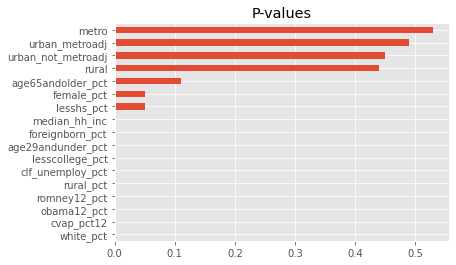

In [36]:
# Plot these to look nice
coeff.sort_values(by='p-values')['p-values'].plot(kind='barh')
plt.title("P-values")
plt.savefig('images/pvalues.png', bbox_inches='tight', dpi=250)

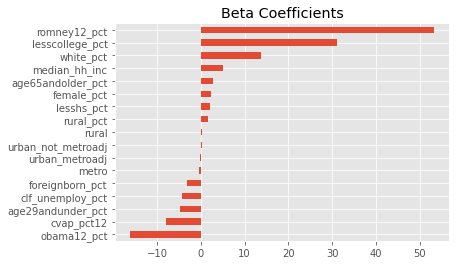

In [38]:
coeff.sort_values(by='beta')['beta'].plot(kind='barh')
plt.title("Beta Coefficients")
plt.savefig('images/betas.png', bbox_inches='tight', dpi=250)

## KFold with linear regression

In [32]:
fold_scores, r_sq, coeffs = modelers.kfold_scores(X_trainn, y_train, 5)
fold_scores, fold_scores.mean(), r_sq, r_sq.mean()

(array([3.85980433, 3.42415782, 3.75036972, 2.74377067, 3.1358319 ]),
 3.3827868871189133,
 array([0.94317874, 0.95174082, 0.94339754, 0.97126931, 0.95692407]),
 0.953302094602997)

In [14]:
coeffs.mean(axis=0)

array([ 1.41262741e+01, -3.39846998e+00,  3.98326835e+00, -5.18218325e+00,
        7.64924040e-01,  4.27973150e+00, -5.14281930e+00,  2.04437502e+00,
        3.10416636e+01,  1.29186492e+00,  5.51369410e+01, -1.42903151e+01,
       -6.31064134e+00,  2.33429489e+13,  2.33429489e+13,  2.33429489e+13,
        2.33429489e+13])

## Save predictions

In [35]:
predictions = pd.DataFrame({'index_values': test_idx, 'trump_predict': y_hat, 'trump_true': y_test, 
              'clinton_predict': 100-y_hat, 'clinton_true': 100-y_test})
predictions.to_csv('data/predictions.csv')

ValueError: not enough values to unpack (expected 3, got 0)